<a href="https://colab.research.google.com/github/nvisagan/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chisquare

In [0]:
columns = ['Party','handicapped-infants','water-project-cost-sharing','adoption-of-the-budget-resolution','physician-fee-freeze','el-salvador-aid'
             ,'religious-groups-in-schools','anti-satellite-test-ban','aid-to-nicaraguan-contras','mx-missile','immigration','synfuels-corporation-cutback'
             ,'education-spending','superfund-right-to-sue','crime','duty-free-exports','export-administration-act-south-africa']

In [0]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data"
df = pd.read_csv(url, header=None, sep = ',',na_values = '?',names = columns)
df.head(5)

,Party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [0]:
df.isna().sum()

Party                                       0
handicapped-infants                        12
water-project-cost-sharing                 48
adoption-of-the-budget-resolution          11
physician-fee-freeze                       11
el-salvador-aid                            15
religious-groups-in-schools                11
anti-satellite-test-ban                    14
aid-to-nicaraguan-contras                  15
mx-missile                                 22
immigration                                 7
synfuels-corporation-cutback               21
education-spending                         31
superfund-right-to-sue                     25
crime                                      17
duty-free-exports                          28
export-administration-act-south-africa    104
dtype: int64

In [0]:
df = df.replace(['n', 'y'],[0,1])
df.head()

,Party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

In [0]:
def conint():
  for col in df.columns[1:]:
    subdf = df[['Party',col]]
    subdf = subdf.dropna()
    con_int_reps = confidence_interval(subdf[subdf['Party'] == 'republican'][col])
    con_int_dems = confidence_interval(subdf[subdf['Party'] == 'democrat'][col])
    if (con_int_reps[0] < con_int_dems[2]) & (con_int_reps[0] > con_int_dems[1]):
      print("Republican mean falls inside democrats confideance interval which means we can't reject the null hypothesis for", col)
    if (con_int_reps[0] > con_int_dems[0]):
      print (f"Republicans support {col} more than Democrats.")
    if (con_int_reps[0] < con_int_dems[0]):
      print (f"Democrats support {col} more than Republicans.")

In [0]:
conint()

Democrats support handicapped-infants more than Republicans.
Republican mean falls inside democrats confideance interval which means we can't reject the null hypothesis for water-project-cost-sharing
Republicans support water-project-cost-sharing more than Democrats.
Democrats support adoption-of-the-budget-resolution more than Republicans.
Republicans support physician-fee-freeze more than Democrats.
Republicans support el-salvador-aid more than Democrats.
Republicans support religious-groups-in-schools more than Democrats.
Democrats support anti-satellite-test-ban more than Republicans.
Democrats support aid-to-nicaraguan-contras more than Republicans.
Democrats support mx-missile more than Republicans.
Republicans support immigration more than Democrats.
Democrats support synfuels-corporation-cutback more than Republicans.
Republicans support education-spending more than Democrats.
Republicans support superfund-right-to-sue more than Democrats.
Republicans support crime more than De

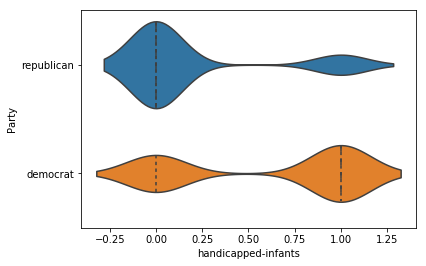

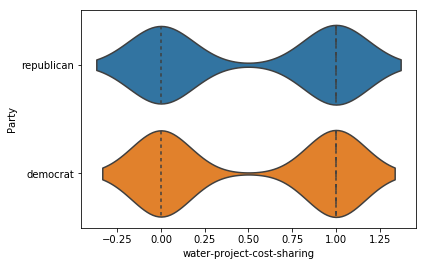

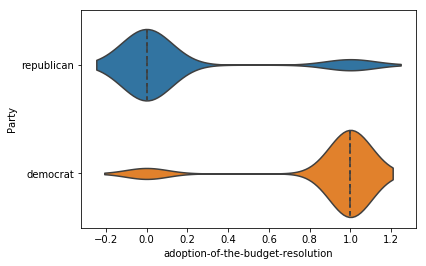

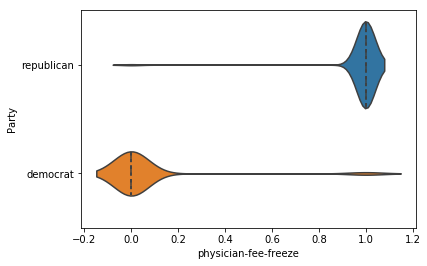

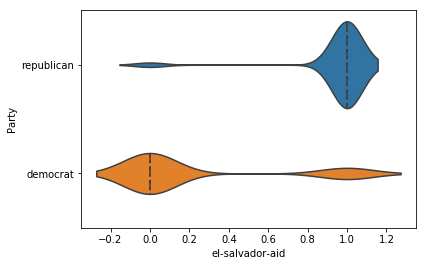

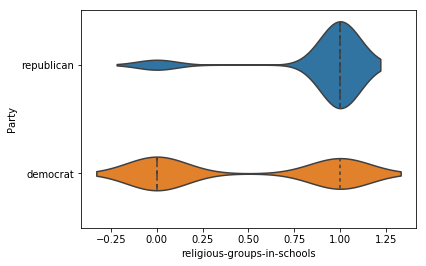

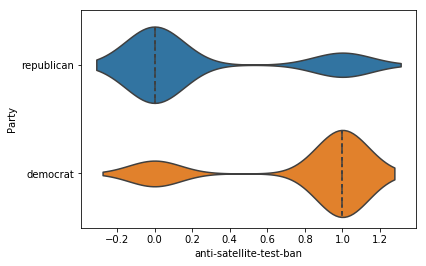

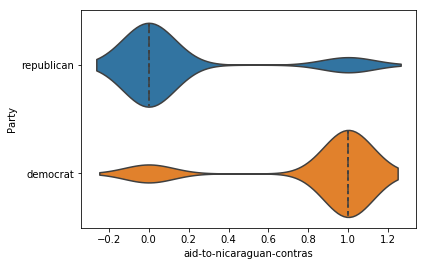

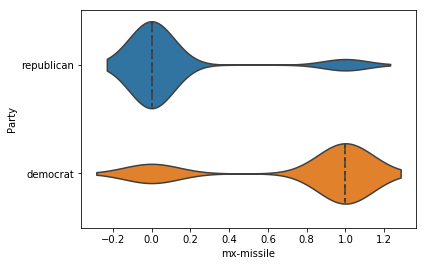

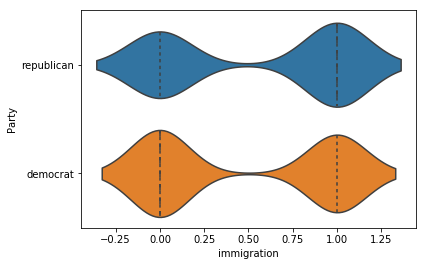

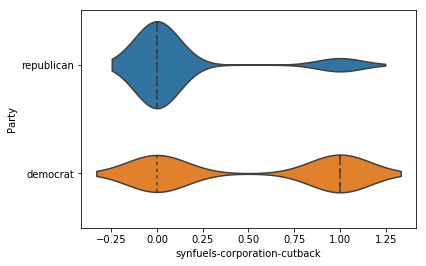

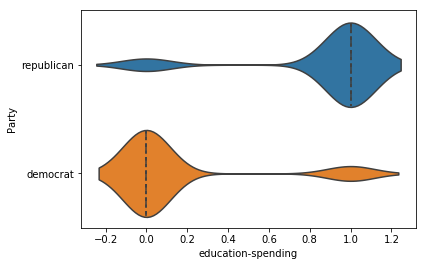

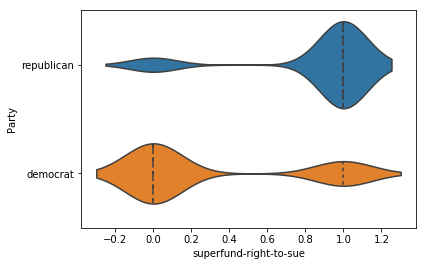

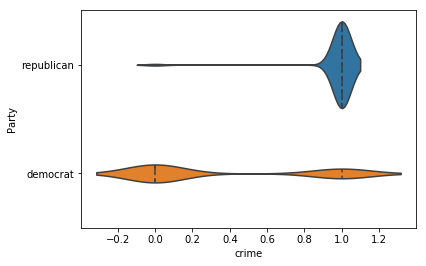

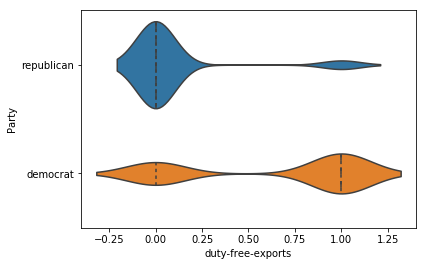

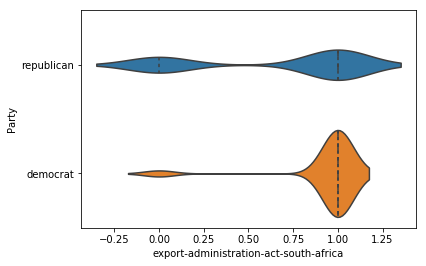

In [0]:
import matplotlib.pyplot as plt

for col in df.columns[1:]:
    subdf = df[['Party',col]]
    subdf = subdf.dropna()
    plt.figure()
    sns.violinplot(y=df['Party'], x=df[col],split=True,inner = 'quartile')

In [0]:
def chisquare():
  for col in df.columns[1:]:
    subdf = df[['Party',col]]
    subdf = subdf.dropna()
    table_observed = pd.crosstab(subdf['Party'], subdf[col])
    table_observed_marg = pd.crosstab(subdf['Party'], subdf[col], margins = True)
    expected = np.outer(table_observed_marg['All'].values[:-1], table_observed_marg.T['All'].values[:-1])/table_observed_marg.T['All'].values[-1]
    table_expected = pd.DataFrame(expected)
    table_expected.columns = table_observed.columns
    table_expected.index = table_observed.index
    deviation = table_observed - table_expected
    deviation_sq = deviation**2
    fraction = deviation_sq/table_expected
    #chi-stat = fraction.values.sum()
    print (f"Issue, {col}. Chi Value {fraction.values.sum()}.")

In [0]:
stats.chisquare()

In [0]:
chisquare()

Issue, handicapped-infants. Chi Value 70.87421431649699.
Issue, water-project-cost-sharing. Chi Value 0.007955791575692298.
Issue, adoption-of-the-budget-resolution. Chi Value 237.778255192867.
Issue, physician-fee-freeze. Chi Value 361.41825999595846.
Issue, el-salvador-aid. Chi Value 216.98408140139546.
Issue, religious-groups-in-schools. Chi Value 77.79074451741738.
Issue, anti-satellite-test-ban. Chi Value 114.70142233396862.
Issue, aid-to-nicaraguan-contras. Chi Value 183.9935799528658.
Issue, mx-missile. Chi Value 163.8145703736439.
Issue, immigration. Chi Value 3.0062714976888616.
Issue, synfuels-corporation-cutback. Chi Value 59.22936050852587.
Issue, education-spending. Chi Value 206.49018306296443.
Issue, superfund-right-to-sue. Chi Value 126.73261895576371.
Issue, crime. Chi Value 163.42932992822648.
Issue, duty-free-exports. Chi Value 117.91892827718182.
Issue, export-administration-act-south-africa. Chi Value 41.309535559507054.


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)